# Modification of the original code
I just took the code of the winner of the RSNA 2022 cervical spine fracture detection competition.  
Link: https://www.kaggle.com/code/haqishen/rsna-2022-1st-place-solution-train-stage1

In [5]:
import os
import sys
import gc
import ast
import cv2
import imageio
import time
import timm
import pickle
import random
import pydicom
import dicomsdl
import argparse
import warnings
import numpy as np
import cupy as cp
import pandas as pd
import glob
import nibabel as nib
from PIL import Image
from tqdm import tqdm
from pylab import rcParams
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold, StratifiedKFold

import gzip
import pickle
from joblib import Parallel, delayed

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset


%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda')
torch.backends.cudnn.benchmark = True

os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
sys.path.append('../')
sys.path.append('../lib_models')
import timm_new


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

# Config

In [6]:
RESOL = [160, 160, 160]
CROP_RESOL = 128

BASE_PATH = '/home/junseonglee/Desktop/01_codes/inputs/rsna-2023-abdominal-trauma-detection'
MASK_SAVE_PATH = f'{BASE_PATH}/mask_preprocessed'
MASK_VALID_PATH = f'{BASE_PATH}/mask_validation'
TRAIN_PATH = f'{BASE_PATH}/train_images'

BATCH_MASK_PRED = 8
N_PROCESS_CROP = 24
PREPROC_NORM_OR_STD = True # True: normalization, False: standardization

seg_weight_name = '231001_timm3d_res10tc_CV0.938.pt'
load_kernel = None
load_last = True
n_blocks = 4
backbone = 'timm/resnet10t.c3_in1k'

data_dir = '../input/rsna-2022-cervical-spine-fracture-detection'
use_amp = True


num_workers = 24
out_dim = 5

model_dir = f'{BASE_PATH}/seg_models_backup'
seg_inference_dir = f'{BASE_PATH}/seg_infer_results'
cropped_img_dir   = f'{BASE_PATH}/3d_preprocessed_crop_ratio'
os.makedirs(model_dir, exist_ok=True)
os.makedirs(MASK_VALID_PATH, exist_ok=True)
os.makedirs(seg_inference_dir, exist_ok = True)
os.makedirs(cropped_img_dir, exist_ok = True)

# Path to save cropped image

In [7]:
df_train = pd.read_csv(f'{BASE_PATH}/train_meta.csv')
mask_paths = []
cropped_paths = []
for i in range(0, len(df_train)):
    row = df_train.iloc[i]
    file_name = row['path'].split('/')[-1]
    mask_paths.append(f'{seg_inference_dir}/{file_name}')
    cropped_paths.append(f'{cropped_img_dir}/{file_name}')
df_train['cropped_path'] = cropped_paths
df_train['mask_path']    = mask_paths
df_train.tail()

df_train.to_csv(f'{BASE_PATH}/train_meta.csv', index = False)

In [8]:
df_train

,patient_id,series,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,fold,path,mask_path,cropped_path
0,26473,11365,1,0,1,0,1,0,0,1,0,0,1,0,0,0,3,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
1,35348,41274,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
2,37260,21973,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
3,37260,19788,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
4,18301,1407,1,0,1,0,1,0,0,1,0,0,1,0,0,0,4,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4706,8076,41087,1,0,1,0,1,0,0,1,0,0,0,1,0,1,1,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
4707,20087,30769,1,0,1,0,0,1,0,1,0,0,1,0,0,1,2,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
4708,20087,45305,1,0,1,0,0,1,0,1,0,0,1,0,0,1,2,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...
4709,43639,64933,1,0,1,0,1,0,0,1,0,0,1,0,0,0,2,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...,/home/junseonglee/Desktop/01_codes/inputs/rsna...


## Get extravasation image-level labels

In [114]:
dcm_list_dict = {}
sample_paths = glob.glob(f'{BASE_PATH}/train_images/*/*')

for i in range(0, len(sample_paths)):
    cur_path = sample_paths[i]
    tmp_split = cur_path.split('/')
    patient, series = int(tmp_split[-2]), int(tmp_split[-1])
    dcm_list = glob.glob(f'{cur_path}/*')
    dcm_extrav_labels = {}
    for dj in range(0, len(dcm_list)):
        dcm_ind = int(dcm_list[dj].split('/')[-1][:-4])
        dcm_extrav_labels[dcm_ind] = 0
    dcm_list_dict[f'{patient}_{series}'] = dcm_extrav_labels
dcm_list_dict['26473_11365'][29]

img_labels_df = pd.read_csv(f'{BASE_PATH}/image_level_labels.csv')
print(img_labels_df.head())

#DCM order is inverse order to match the actual image preprocessing below
img_labels_df = pd.read_csv(f'{BASE_PATH}/image_level_labels.csv')
np.unique(img_labels_df['injury_name'])
img_labels_df = img_labels_df.groupby(['patient_id', 'series_id'])

for ind, samp in img_labels_df:
    row = samp.iloc[0]
    patient = row['patient_id']
    series  = row['series_id']
    cur_dict = dcm_list_dict[f'{patient}_{series}'].copy()
    for si in range(0, len(samp)):
        row = samp.iloc[si]
        if(row['injury_name']=='Active_Extravasation'):
            #here inverse!
            cur_dict[int(row['instance_number'])] = 1    
    cur_keys = sorted(cur_dict.keys())
    sorted_cur_labels = np.zeros(len(cur_keys))
    
    for i, k in enumerate(cur_keys):
        sorted_cur_labels[i] = cur_dict[k]
    sorted_cur_labels = np.flip(sorted_cur_labels)
    dcm_list_dict[f'{patient}_{series}'] = sorted_cur_labels
    
for i, k in enumerate(dcm_list_dict):
    if type(dcm_list_dict[k]) is dict:
        dcm_list_dict[k] = np.zeros(len(dcm_list_dict[k]))

   patient_id  series_id  instance_number           injury_name
0       10004      21057              362  Active_Extravasation
1       10004      21057              363  Active_Extravasation
2       10004      21057              364  Active_Extravasation
3       10004      21057              365  Active_Extravasation
4       10004      21057              366  Active_Extravasation


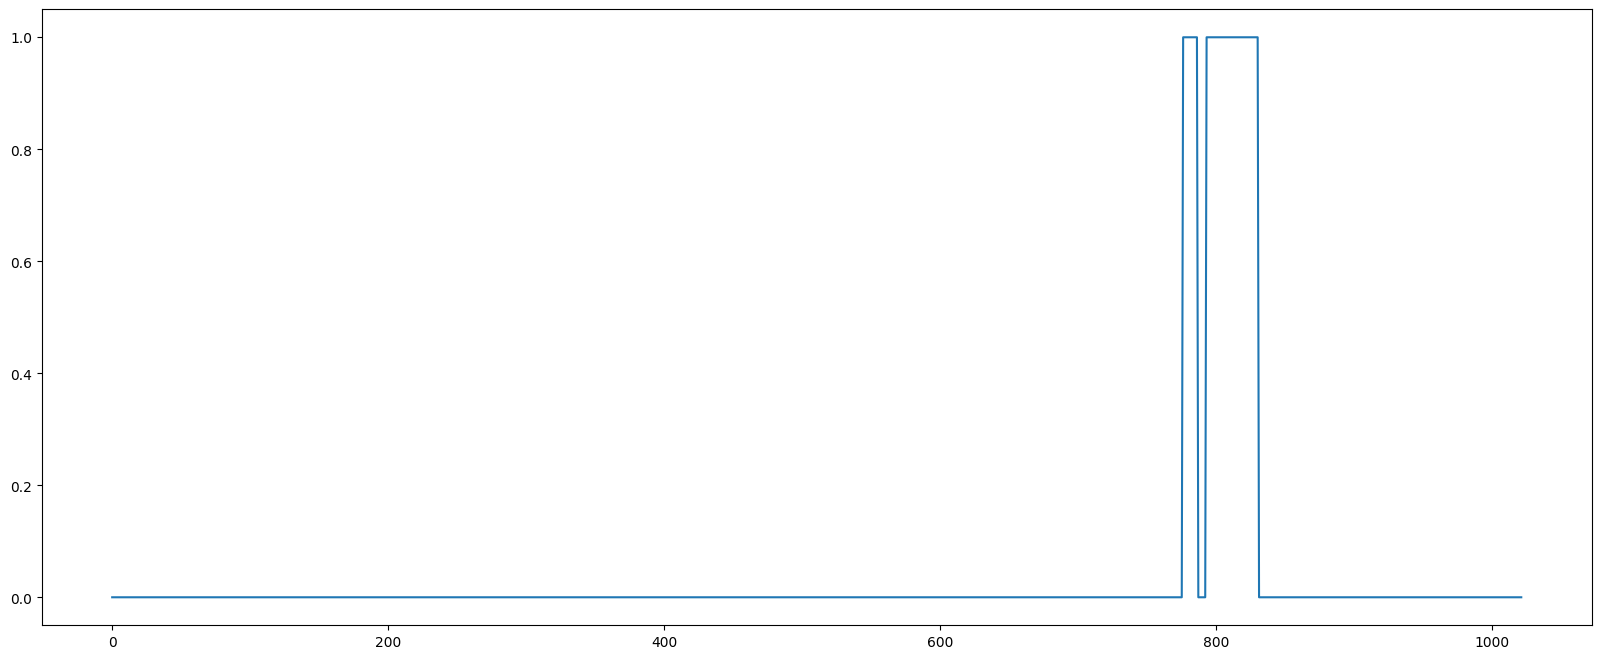

In [116]:
plt.plot(np.arange(0, len(dcm_list_dict['10004_21057'])), dcm_list_dict['10004_21057'])

# Dataset

In [5]:
def compress(name, data):
    with gzip.open(name, 'wb') as f:
        pickle.dump(data, f)

def decompress(name):
    with gzip.open(name, 'rb') as f:
        data = pickle.load(f)
    return data

def compress_fast(name, data):
    with open(name, 'wb') as f:
        pickle.dump(data, f)

def decompress_fast(name):
    with open(name, 'rb') as f:
        data = pickle.load(f)
    return data

class SEGDataset(Dataset):
    def __init__(self, df, mode):

        self.df = df.reset_index()
        self.mode = mode

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        image = decompress(row['path']).unsqueeze(0)
        #image = torch.from_numpy(image).to(torch.float32)
        save_path = row['mask_path']

        return image, save_path


# Model

In [6]:
class TimmSegModel(nn.Module):
    def __init__(self, backbone, segtype='unet', pretrained=False):
        super(TimmSegModel, self).__init__()

        self.encoder = timm_new.create_model(
            backbone,
            in_chans=1,
            features_only=True,
            pretrained=pretrained
        )
        g = self.encoder(torch.rand(1, 1, 64, 64))
        encoder_channels = [1] + [_.shape[1] for _ in g]
        decoder_channels = [256, 128, 64, 32, 16]
        if segtype == 'unet':
            self.decoder = smp.unet.decoder.UnetDecoder(
                encoder_channels=encoder_channels[:n_blocks+1],
                decoder_channels=decoder_channels[:n_blocks],
                n_blocks=n_blocks,
            )

        self.segmentation_head = nn.Conv2d(decoder_channels[n_blocks-1], out_dim, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    def forward(self,x):
        global_features = [0] + self.encoder(x)[:n_blocks]
        seg_features = self.decoder(*global_features)
        seg_features = self.segmentation_head(seg_features)
        return seg_features

In [7]:
from timm.models.layers.conv2d_same import Conv2dSame
from conv3d_same import Conv3dSame


def convert_3d(module):

    module_output = module
    if isinstance(module, torch.nn.BatchNorm2d):
        module_output = torch.nn.BatchNorm3d(
            module.num_features,
            module.eps,
            module.momentum,
            module.affine,
            module.track_running_stats,
        )
        if module.affine:
            with torch.no_grad():
                module_output.weight = module.weight
                module_output.bias = module.bias
        module_output.running_mean = module.running_mean
        module_output.running_var = module.running_var
        module_output.num_batches_tracked = module.num_batches_tracked
        if hasattr(module, "qconfig"):
            module_output.qconfig = module.qconfig
            
    elif isinstance(module, Conv2dSame):
        module_output = Conv3dSame(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.Conv2d):
        module_output = torch.nn.Conv3d(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
            padding_mode=module.padding_mode
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.MaxPool2d):
        module_output = torch.nn.MaxPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            dilation=module.dilation,
            ceil_mode=module.ceil_mode,
        )
    elif isinstance(module, torch.nn.AvgPool2d):
        module_output = torch.nn.AvgPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            ceil_mode=module.ceil_mode,
        )

    for name, child in module.named_children():
        module_output.add_module(
            name, convert_3d(child)
        )
    del module

    return module_output

m = TimmSegModel(backbone)
m = convert_3d(m)
m(torch.rand(1, 1, 128,128,128)).shape

torch.Size([1, 5, 128, 128, 128])

# Inference mask

In [8]:
def infer_func(model, loader_valid):
    model.eval()
    valid_loss = []
    outputs = []
    th = 0.1
    batch_metrics = [[]]
    bar = tqdm(loader_valid)
    
    with torch.no_grad():
        with amp.autocast():
            for images, save_paths in bar:
                images = images.cuda()
                logits = model(images)
                preds = (logits.sigmoid() > th).float().detach().cpu().numpy()
                y_preds = (preds+0.1).astype(np.uint8)
                def save_mask(ind, preds = y_preds): 
                    compress(save_paths[ind], preds[ind])
                
                Parallel(n_jobs = len(y_preds))(delayed(save_mask)(i) for i in range(len(y_preds)))

In [9]:
def run(fold):
    model_file = os.path.join(model_dir, f'{seg_weight_name}')
    dataset_train = SEGDataset(df_train, 'valid')
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_MASK_PRED, shuffle=False, num_workers=BATCH_MASK_PRED)

    model = TimmSegModel(backbone, pretrained=True)
    model = convert_3d(model)

    model.load_state_dict(torch.load(model_file))
    model = model.to(device)

    print(len(dataset_train))
    
    infer_func(model, loader_train)

    del model
    torch.cuda.empty_cache()
    gc.collect()


In [10]:
#run(0)

# Postprocss to get crop regions

In [11]:
#Returns GPU array
def standardize_pixel_array(pixel_array, dcm_rows):
    """
    Source : https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection/discussion/427217
    """
    # Correct DICOM pixel_array if PixelRepresentation == 1.
    for z in range(0, len(pixel_array)):
        if int(dcm_rows[z]['PixelRepresentation']) == 1:
            bit_shift = dcm_rows[z]['BitsAllocated'] - dcm_rows[z]['BitsStored']
            dtype = pixel_array[z].dtype 
            pixel_array[z] = (pixel_array[z] << bit_shift).astype(dtype) >>  bit_shift

    pixel_array = torch.from_numpy(pixel_array.astype(np.float16)).to(DEVICE).to(torch.float16)    

    for z in range(0, len(pixel_array)):
        intercept = float(dcm_rows[z]['RescaleIntercept'])
        slope = float(dcm_rows[z]['RescaleSlope'])
        center = int(dcm_rows[z]['WindowCenter'])
        width = int(dcm_rows[z]['WindowWidth'])
        low = center - width / 2
        high = center + width / 2    
        
        pixel_array[z] = (pixel_array[z] * slope) + intercept
        pixel_array[z] = torch.clip(pixel_array[z], low, high)
        
    gc.collect()    
    return pixel_array

#to make longest axis to z
def get_new_axis_order(max_ind, n_dims=3):
    origin_order = np.arange(0, 3)
    new_order = origin_order.copy()
    new_order[0] = max_ind
    new_order[max_ind]=0
    return new_order

In [12]:
#The order of the crop region data format
#Z start/end, Y start/end, X start/end for each mask channels + total region for the extravasation prediction
def calc_crop_region(mask):
    crop_range = np.zeros((6, 6))
    crop_range[:,::2]=10000
    mask_z = np.max(mask, axis = (2, 3)).astype(bool)
    mask_y = np.max(mask, axis = (1, 3)).astype(bool)
    mask_x = np.max(mask, axis = (1, 2)).astype(bool)
    
    template_zrange = np.arange(0, RESOL[0])
    template_yrange = np.arange(0, RESOL[1])
    template_xrange = np.arange(0, RESOL[2])
        
    for mi in range(0, 5):
        zrange = template_zrange[mask_z[mi]]
        yrange = template_yrange[mask_y[mi]]
        xrange = template_xrange[mask_x[mi]]
        # For incomplete organ
        if(len(zrange)==0):
            zrange = template_zrange.copy()
            yrange = template_yrange.copy()
            xrange = template_xrange.copy()

        crop_range[mi] = np.min(zrange), np.max(zrange)+1, np.min(yrange), np.max(yrange)+1, np.min(xrange), np.max(xrange)+1

    crop_range[5] = np.min(crop_range[:5, 0]), np.max(crop_range[:5, 1]), np.min(crop_range[:5, 2]), \
                    np.max(crop_range[:5, 3]), np.min(crop_range[:5,4]), np.max(crop_range[:5, 5])
    
    crop_range[:,:2]/=len(mask_z[0])
    crop_range[:,2:4]/=len(mask_y[0])
    crop_range[:,4:6]/=len(mask_x[0])

    # Then make extravasation (# 5 mask) to reference one and convert other mask's crop respective to it
    # --> To minimize the loading size due to speed issue.
    zmin, rel_zrange = crop_range[5,0], crop_range[5,1]-crop_range[5,0]
    ymin, rel_yrange = crop_range[5,2], crop_range[5,3]-crop_range[5,2]
    xmin, rel_xrange = crop_range[5,4], crop_range[5,5]-crop_range[5,4]

    crop_range[:5,:2] = (crop_range[:5,:2]-zmin)/rel_zrange
    crop_range[:5,2:4] = (crop_range[:5,2:4]-ymin)/rel_yrange
    crop_range[:5,4:6] = (crop_range[:5,4:6]-xmin)/rel_xrange

    return crop_range

def crop_resize_avg_and_std_3d(data, region, resize_shape, is_norm = PREPROC_NORM_OR_STD):
    shapes = data.shape
    region[:2]*=shapes[0]
    region[2:4]*=shapes[1]
    region[4:6]*=shapes[2]
    region = region.astype(int)

    cropped = torch.clone(data[region[0]:region[1], region[2]:region[3], region[4]:region[5]])    
    
    #resize xy
    cropped = transforms.Resize((int(resize_shape[1]), int(resize_shape[2])), antialias = True)(cropped)
    
    #zyx to xzy
    cropped = torch.permute(cropped, (2, 0, 1))
    #Resize yz
    cropped = transforms.Resize((int(resize_shape[0]), int(resize_shape[1])), antialias = True)(cropped)
    #xzy to zyx
    cropped = torch.permute(cropped, (1, 2, 0))

    if is_norm:
        bottom = torch.min(cropped)
        cropped -= bottom
        top    = torch.max(cropped)
        cropped/=top
        del top, bottom
    else:
        avg = torch.mean(cropped, (0, 1, 2))
        std = torch.std(cropped, (0, 1, 2))
        cropped = (cropped-avg)/std
        del avg, std
        
    del shapes, region
    gc.collect()
    torch.cuda.empty_cache()
    return cropped

# Read each slice and stack them to make 3d data
def process_3d_crop(save_path, mask_path, resize_shapes, data_path = TRAIN_PATH):
    tmp = save_path.split('/')[-1][:-4]
    tmp = tmp.split('_')
    patient, study = int(tmp[0]), int(tmp[1])
    
    mask = decompress(mask_path)
    crop_regions = calc_crop_region(mask)
    absolute_crop = crop_regions[5].copy() # To load minimum pixels...

    del mask
    gc.collect()
    crop_regions[5] = 0, 1, 0, 1, 0, 1

    imgs = {}    
    for f in sorted(glob.glob(data_path + f'/{patient}/{study}/*.dcm')):  
        pos_z = -int((f.split('/')[-1])[:-4])
        imgs[pos_z] = f

    imgs_3d = []
    n_imgs = len(imgs)    
    z_crop_range= (absolute_crop[0:2]*n_imgs).astype(int)
    
    dcm_rows = []
    for i, k in enumerate(sorted(imgs.keys())):
        if(i >= z_crop_range[0] and i < z_crop_range[1]):
            IS_XY_CROP = False
            f = imgs[k]
            #Exception for the corrupted dicom file
            if (f=='/kaggle/input/rsna-2023-abdominal-trauma-detection/test_images/3124/5842/514.dcm'):
                continue
            opened_dicom = dicomsdl.open(f)
            img = opened_dicom.pixelData(storedvalue=True)
            params = opened_dicom.getPixelDataInfo()

            if not IS_XY_CROP:
                img_shape = np.shape(img)
                xy_crop_range = absolute_crop[2:].copy()   
                xy_crop_range[0:2]*=img_shape[0]
                xy_crop_range[2:4]*=img_shape[1]            
                xy_crop_range = xy_crop_range.astype(int)                
                IS_XY_CROP = True
                
            img = img[xy_crop_range[0]:xy_crop_range[1], xy_crop_range[2]:xy_crop_range[3]]             

            #dcm_row = pd.DataFrame.from_dict(params)                   
            dcm_rows.append(params)                  
            imgs_3d.append(img[None])

    del opened_dicom
    gc.collect()
                
    imgs_3d = np.vstack(imgs_3d)

    imgs_3d  = standardize_pixel_array(imgs_3d, dcm_rows)

    min_imgs = torch.min(imgs_3d)
    max_imgs = torch.max(imgs_3d)
        
    imgs_3d = ((imgs_3d - min_imgs) / (max_imgs - min_imgs + 1e-6))

    if str(dcm_rows[0]['PhotometricInterpretation']) == "MONOCHROME1":
        imgs_3d = 1.0 - imgs_3d

    #Loaded original imgs_3d    
    origin_shape = imgs_3d.shape
    for i in range(0, 6):    
        #To deal with almost not detected slices
        try:   
            # To deal with possible noises
            if(((crop_regions[i,1]-crop_regions[i,0]) < 10/origin_shape[0]) or 
                ((crop_regions[i,3]-crop_regions[i,2]) < 10/origin_shape[1]) or 
                ((crop_regions[i,5]-crop_regions[i,4]) < 10/origin_shape[2])):
                dummy_failure_function()
            
            processed_img_3d = (crop_resize_avg_and_std_3d(imgs_3d, crop_regions[i], resize_shapes[i])).to(torch.float16).to('cpu')
            compress_fast(f'{save_path}_{i}', processed_img_3d)      

            del processed_img_3d
            gc.collect()
        except:
            processed_img_3d = (crop_resize_avg_and_std_3d(imgs_3d, np.array([0, 1, 0, 1, 0, 1]), resize_shapes[i])).to(torch.float16).to('cpu')
            compress_fast(f'{save_path}_{i}', processed_img_3d)
            del processed_img_3d
            gc.collect()  

    del imgs, img, imgs_3d
    gc.collect()
    torch.cuda.empty_cache()
    
def calc_size_3d_crop(save_path, mask_path, data_path = TRAIN_PATH):
    tmp = save_path.split('/')[-1][:-4]
    tmp = tmp.split('_')
    patient, study = int(tmp[0]), int(tmp[1])
    
    mask = decompress(mask_path)
    crop_regions = calc_crop_region(mask)
    absolute_crop = crop_regions[5].copy() # To load minimum pixels...

    crop_regions[5] = 0, 1, 0, 1, 0, 1

    imgs = {}    
    
    for f in sorted(glob.glob(data_path + f'/{patient}/{study}/*.dcm')):      
        try:            
            img = dicomsdl.open(f).pixelData(storedvalue=True)
            img_shape = np.shape(img)
            xy_crop_range = absolute_crop[2:].copy()   
            xy_crop_range[0:2]*=img_shape[0]
            xy_crop_range[2:4]*=img_shape[1]            
            xy_crop_range = xy_crop_range.astype(int)
            img = img.astype(float)
            break
        except:
            continue
    
    base_crop_shape = np.zeros(3, float)
    base_crop_shape[:] = absolute_crop[1::2] - absolute_crop[0::2]
    base_crop_shape[0]*= len(glob.glob(data_path + f'/{patient}/{study}/*.dcm'))
    base_crop_shape[1:3] = xy_crop_range[1::2] - xy_crop_range[0::2]
    
    all_crop_shape = crop_regions[:,1::2] - crop_regions[:,0::2]
    for i in range(0, 6):
        all_crop_shape[i] *= base_crop_shape
    del img
    gc.collect()
    return all_crop_shape

# Calculate average crop size

In [13]:
# Preprocess dataset
rng_samples = np.linspace(0, len(df_train), N_PROCESS_CROP+1, dtype = int)
def process_3d_wrapper(process_ind, rng_samples = rng_samples, train_meta_df = df_train):
    partial_crop_shapes = []
    for i in tqdm(range(rng_samples[process_ind], rng_samples[process_ind+1])):
        partial_crop_shapes.append(calc_size_3d_crop(df_train.iloc[i]['cropped_path'], df_train.iloc[i]['mask_path'])[None])
    partial_crop_shapes = np.vstack(partial_crop_shapes)
    return partial_crop_shapes

In [14]:
%%time
all_crop_shapes = Parallel(n_jobs = N_PROCESS_CROP)(delayed(process_3d_wrapper)(i) for i in range(N_PROCESS_CROP))
all_crop_shapes = np.vstack(all_crop_shapes)
avg_all_crop_shapes = np.average(all_crop_shapes, axis = 0)

100%|██████████| 196/196 [00:22<00:00,  8.89it/s]


CPU times: user 380 ms, sys: 486 ms, total: 865 ms
Wall time: 22.9 s


100%|██████████| 197/197 [00:22<00:00,  8.82it/s]


# Cropwise resize

In [15]:
for i in range(0, len(avg_all_crop_shapes)):
    cur_shape = avg_all_crop_shapes[i]
    rescale_factor =  (CROP_RESOL**3/(cur_shape[0]*cur_shape[1]*cur_shape[2]))**(1/3)
    avg_all_crop_shapes[i,:]*=rescale_factor

avg_all_crop_shapes+=0.1
avg_all_crop_shapes = avg_all_crop_shapes.astype(int)
avg_all_crop_shapes

array([[131, 107, 148],
       [107, 129, 150],
       [105, 138, 144],
       [ 77, 150, 180],
       [ 85, 155, 158],
       [123, 109, 155]])

In [16]:
# Preprocess dataset
rng_samples = np.linspace(0, len(df_train), N_PROCESS_CROP+1, dtype = int)
def process_3d_wrapper(process_ind, rng_samples = rng_samples, train_meta_df = df_train, resize_shapes =  avg_all_crop_shapes):
    for i in tqdm(range(rng_samples[process_ind], rng_samples[process_ind+1])):
        if not os.path.isfile(f"{df_train.iloc[i]['cropped_path']}_0"):
            process_3d_crop(train_meta_df.iloc[i]['cropped_path'], train_meta_df.iloc[i]['mask_path'], resize_shapes)     
        
        #For error correction
        else:            
            try:
                data = decompress(f"df_train.iloc[i]['cropped_path']_0")
            except: 
                process_3d_crop(train_meta_df.iloc[i]['cropped_path'], train_meta_df.iloc[i]['mask_path'], resize_shapes)  
        

In [17]:
%%time
Parallel(n_jobs = N_PROCESS_CROP)(delayed(process_3d_wrapper)(i) for i in range(N_PROCESS_CROP))

 99%|█████████▉| 195/196 [08:37<00:00,  1.04it/s]

CPU times: user 2 s, sys: 592 ms, total: 2.59 s
Wall time: 8min 40s


100%|██████████| 196/196 [08:38<00:00,  2.65s/it]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [18]:
ind = 8
cropped = decompress_fast(f"{df_train.iloc[ind]['cropped_path']}_1")
mask    = decompress(df_train.iloc[ind]['mask_path'])
img     = decompress(df_train.iloc[ind]['path'])

In [20]:
if (np.abs(np.average(cropped.numpy().astype(np.float64))))>0.01:
    print('standardization not performed')